# Homework 3:  Power System Event Detection Using Graph Signal Processing Using PMU Data

## Notebook Outline

    1. Load the Data
    2. Calculate the Temporal Coefﬁcient Matrix by Vector Autoregressive (VAR) process.
    3. Calculate the Spatial Coefﬁcient Matrix by Pearson correlation coefficients.
    4. Calculate the Graph Laplacian Matrix.
    5. Calculate the Graph Fourier Transform (GFT) Matrix.
    6. Use the calculated matrices for event indicator calculation.

In [1]:
# Load numpy library as "np", which can handle large matrices and provides some mathematical functions.
import numpy as np 
# Load pandas as "pd", which is useful when working with data tables. 
import pandas as pd 
# Load the SciPy, which provides many useful tools for scientific computing
import scipy
# Load random, which provide some randomize functions.
import random
# Load a function pyplot as "plt" to plot figures.
import matplotlib.pyplot as plt
# Load functions to calculate precision, and recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Load the VAR function for Vector Autoregression
from statsmodels.tsa.api import VAR

# Setup the random seed for reproducibility
seed = 1234
random.seed(seed)
np.random.seed(seed)

In [2]:
# The root directory of the pmuBAGE data
pmuBAGE_data_dir = "../data/pmuBAGE/data"

# Number of the tensor for voltage and frequency
voltage_tensor_number = 31
frequency_tensor_number = 21

# Load each tensors of voltage events and concatenate them as a big tensor.
voltage_tensor_list = []
for idx in range(voltage_tensor_number):
    voltage_sub_tensor = np.load(f"{pmuBAGE_data_dir}/voltage/voltage_{idx}.npy")
    voltage_tensor_list.append(voltage_sub_tensor)
voltage_tensor = np.concatenate(voltage_tensor_list, axis=0)


# Load each tensors of frequency events and concatenate them as a big tensor.
frequency_tensor_list = []
for idx in range(frequency_tensor_number):
    frequency_sub_tensor = np.load(f"{pmuBAGE_data_dir}/frequency/frequency_{idx}.npy")
    frequency_tensor_list.append(frequency_sub_tensor)
frequency_tensor = np.concatenate(frequency_tensor_list, axis=0)

# Transpose the big tensor as (event_idx, timestamp, PMU_idx, measurements)
voltage_tensor = np.transpose(voltage_tensor, (0, 3, 2, 1))
frequency_tensor = np.transpose(frequency_tensor, (0, 3, 2, 1))

# Print the shape of the voltage event
print(voltage_tensor.shape)
print(frequency_tensor.shape)

(620, 600, 100, 4)
(84, 600, 100, 4)


In [3]:
single_event = voltage_tensor[0]

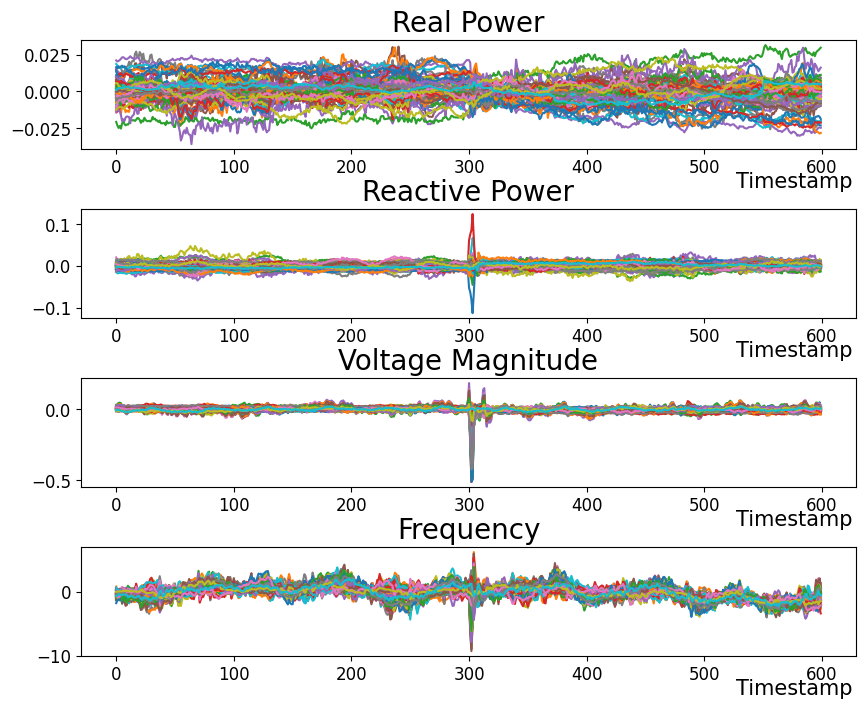

In [4]:
def visualization(event, save_path='', isSave=False):
    plt.style.context(['ieee', 'no-latex'])

    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.55)
    plt.tick_params(labelsize=15)

    axes[0].set_title("Real Power", fontsize=20)
    axes[0].plot(event[:, :, 0])
    axes[0].tick_params(labelsize=12)
    axes[0].set_xlabel('Timestamp', fontsize=15)
    axes[0].xaxis.set_label_coords(0.92, -0.21)

    axes[1].set_title("Reactive Power", fontsize=20)
    axes[1].plot(event[:, :, 1])
    axes[1].tick_params(labelsize=12)
    axes[1].set_xlabel('Timestamp', fontsize=15)
    axes[1].xaxis.set_label_coords(0.92, -0.21)

    axes[2].set_title("Voltage Magnitude", fontsize=20)
    axes[2].plot(event[:, :, 2])
    axes[2].tick_params(labelsize=12)
    axes[2].set_xlabel('Timestamp', fontsize=15)
    axes[2].xaxis.set_label_coords(0.92, -0.21)

    axes[3].set_title("Frequency", fontsize=20)
    axes[3].plot(event[:, :, 3])
    axes[3].tick_params(labelsize=12)
    axes[3].set_xlabel('Timestamp', fontsize=15)
    axes[3].xaxis.set_label_coords(0.92, -0.21)

    if isSave == True:
        plt.savefig(save_path)
    plt.show()
    
    return

visualization(single_event)

In [5]:
# Training Data (Use the first 100 timestamp voltage channel to calculate Graph Laplacian)
train_steps = 120
train_data = single_event[:, :, 2][:train_steps]
print(f"Train data shape is: {train_data.shape}.")
print(f"{train_data.shape[0]} timestamps, {train_data.shape[1]} PMU, voltage channel measurement.")

Train data shape is: (120, 100).
120 timestamps, 100 PMU, voltage channel measurement.


In [6]:
# Calculate the Temporal Coefﬁcient between two timestamps of PMUs

def fit_var_model(train_data, maxlags=1):

    ##-----------------------------------------------------------------------##
    ##---------------------Students start filling below----------------------##
    ##-----------------------------------------------------------------------##
    
    """
        Fit the train_data by VAR model with maxlag = 1
        return the first-order Temporal Coefﬁcient matrix.
    """
    model = VAR(train_data)

    result = model.fit(maxlags=maxlags)

    temporal_weight = result.params[1:]

    ##-----------------------------------------------------------------------##
    ##------------------------------End filling------------------------------##
    ##-----------------------------------------------------------------------##
    return temporal_weight

# Should be (100, 100)
temporal_weight = fit_var_model(train_data)
print(f"The shape of the temporal Coefﬁcient: {temporal_weight.shape}.")

The shape of the temporal Coefﬁcient: (100, 100).


In [7]:
# Calculate the Spatial Coefﬁcient between different PMUs

def get_spatial_weight(train_data):
    
    ##-----------------------------------------------------------------------##
    ##---------------------Students start filling below----------------------##
    ##-----------------------------------------------------------------------##
    
    """
        1. Calculate the Pearson correlation coefficient between different PMUs
        2. Set the diagonal of the coefficient matrix to 0
    """

    spatial_weight = np.corrcoef(train_data, rowvar=False)
    np.fill_diagonal(spatial_weight, 0)
    
    ##-----------------------------------------------------------------------##
    ##------------------------------End filling------------------------------##
    ##-----------------------------------------------------------------------##
    
    return spatial_weight

# Should be (100, 100)
spatial_weight = get_spatial_weight(train_data)
print(f"The shape of the spatial Coefﬁcient: {spatial_weight.shape}.")

The shape of the spatial Coefﬁcient: (100, 100).


In [9]:
# Calculate the first-order graph Laplacian matrix

def get_norm_laplacian(spatial_weight, temporal_weight):
    
    ##-----------------------------------------------------------------------##
    ##---------------------Students start filling below----------------------##
    ##-----------------------------------------------------------------------##
    
    """
        Given the spatial matrix: S, temporal matrix: T
        The weighted adjacency matrix A is defined as:
            A = | S T |
                | T S |
        This task is required to calculate the degree matrix: D, and graph Laplacian matrix: L
            L = D - A
    """
    
    A = np.block([[spatial_weight, temporal_weight],
                  [temporal_weight, spatial_weight]])
    D = np.diag(np.sum(A, axis=1))
    L = D-A
    
    ##-----------------------------------------------------------------------##
    ##------------------------------End filling------------------------------##
    ##-----------------------------------------------------------------------##
    
    return L


# Should be (200, 200)
L = get_norm_laplacian(spatial_weight, temporal_weight)
print(f"The shape of the graph Laplacian matrix is: {L.shape}")


The shape of the graph Laplacian matrix is: (200, 200)


In [10]:
# Calculate the Graph Fourier Transform (GFT) matrix

def get_gft_transformation(L):
    
    ##-----------------------------------------------------------------------##
    ##---------------------Students start filling below----------------------##
    ##-----------------------------------------------------------------------##
    
    """
        Calculate the Graph Fourier Transform (GFT) matrix
        Get the eigenvectors and eigenvalue of the graph Laplacian matrix
        return the sorted eigenvectors matrix (as transformation matrix) and eigenvalues.
    """
    # Get the eigenvectors and eigenvalue of the graph Laplacian matrix
    eig_values, eig_vectors = np.linalg.eigh(L)
    idx_sort = np.argsort(eig_values)
    eig_sort = eig_values[idx_sort]
    transform_matrix = eig_vectors[:, idx_sort]
    
    ##-----------------------------------------------------------------------##
    ##------------------------------End filling------------------------------##
    ##-----------------------------------------------------------------------##
    
    return transform_matrix, eig_sort

# Should be (200, 200)
transform_matrix, eig_sort = get_gft_transformation(L)
print(f"The shape of the Graph Fourier Transform (GFT) matrix is: {transform_matrix.shape}")
print(f"The shape of the eigenvalues is: {eig_sort.shape}")


The shape of the Graph Fourier Transform (GFT) matrix is: (200, 200)
The shape of the eigenvalues is: (200,)


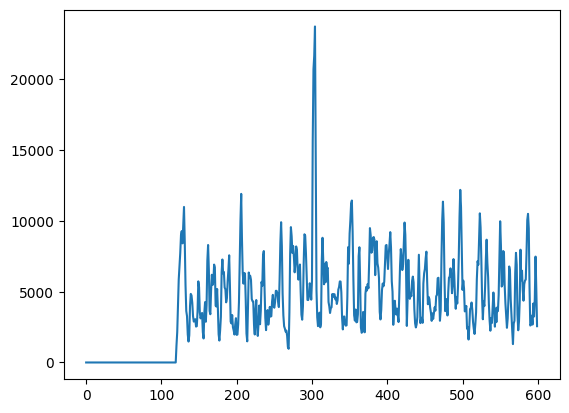

In [11]:
# Calculate the event indicator on Single channel

# Voltage channel
test_channel = single_event[:, :, 2]
norm_window_size = 30
graph_window_size = 2


def calculate_single_channel_indicator(test_channel, transform_matrix, eig_sort):
    # Training part fill by zero
    indicator = np.array([0] * train_steps)
    for ts in range(train_steps, test_channel.shape[0]):
        # Get the mean and standard diviation of the recent measurement 
        window_data = test_channel[ts - norm_window_size: ts, :]
        window_sigma = window_data.std(axis=0)
        window_mu = window_data.mean(axis=0)
        window_sigma[window_sigma <= 0.01] = 1
        
        # Normalize the current timestamp and previous timestamp
        graph_signal = np.divide(test_channel[ts - graph_window_size: ts] - window_mu, window_sigma)
        graph_signal = graph_signal.flatten()
        
        ##-----------------------------------------------------------------------##
        ##---------------------Students start filling below----------------------##
        ##-----------------------------------------------------------------------##
        
        # Use the Graph Fourier Transform (GFT) matrix to transform the PMU data
        """ graph_fourier = transform_matrix dot graph_signal """
        graph_fourier = np.dot(transform_matrix, graph_signal)

        # Use the eigenvalues and "graph_fourier" to get the event indicator
        """ event_indicator = eigenvalues dot abs(graph_fourier) """
        fourier_sig_sum = np.dot(eig_sort, np.abs(graph_fourier))
        
        ##-----------------------------------------------------------------------##
        ##------------------------------End filling------------------------------##
        ##-----------------------------------------------------------------------##
        
        # Append the current timestamp's result to the array
        indicator = np.append(indicator, fourier_sig_sum)
    
    return indicator


indicator = calculate_single_channel_indicator(test_channel, transform_matrix, eig_sort)
plt.plot(indicator)


In [12]:
# Combine the above implemented method together, calculate the event indicator over all channels of one event sample

def calculate_event_indicator(single_event, train_steps=120):
    # Get train data
    train_data = single_event[:, :, 2][:train_steps]
    # Get Temporal Coefﬁcient
    temporal_weight = fit_var_model(train_data)
    print(f"The shape of the temporal correlation: {temporal_weight.shape}.")
    # Get Spatial Coefﬁcient
    spatial_weight = get_spatial_weight(train_data)
    print(f"The shape of the spatial correlation: {spatial_weight.shape}.")
    # Get graph laplacia matrix
    L = get_norm_laplacian(spatial_weight, temporal_weight)
    print(f"The shape of the graph Laplacian matrix is: {L.shape}.")
    # Get graph Graph Fourier Transform (GFT) matrix
    transform_matrix, eig_sort = get_gft_transformation(L)
    print(f"The shape of the Graph Fourier Transform (GFT) matrix is: {transform_matrix.shape}.")
    
    channel_idx = {"Active Power": 0, "Reactive Power": 1, "Voltage": 2, "Frequency": 3}
    
    res = dict()
    for channel_name, channel_idx in channel_idx.items():
        test_channel = single_event[:, :, channel_idx]
        indicator = calculate_single_channel_indicator(test_channel, transform_matrix, eig_sort)
        res[channel_name] = indicator
    
    return res

single_event = voltage_tensor[0]
single_event_res = calculate_event_indicator(single_event, train_steps=120)

The shape of the temporal correlation: (100, 100).
The shape of the spatial correlation: (100, 100).
The shape of the graph Laplacian matrix is: (200, 200).
The shape of the Graph Fourier Transform (GFT) matrix is: (200, 200).


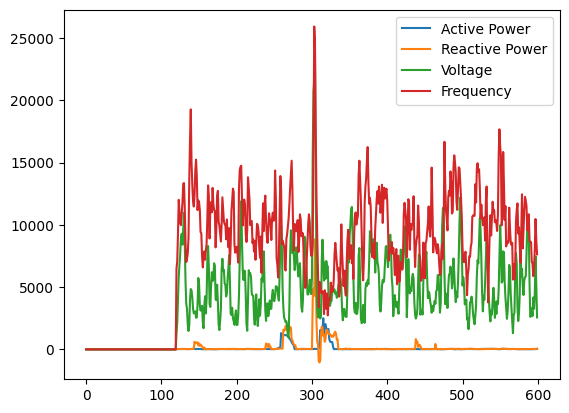

In [13]:
# Plot the result

for channel_name, indicator in single_event_res.items():
    plt.plot(indicator, label=channel_name)

plt.legend()